# SPRINT 2: Building Energy Consumption Predictor (BECP)
### *by Jose Correa*

__________________

<a id='data-intro'></a>

# Introduction

In this Sprint 2 we leverage insights gained from our past two capstone submissions, propelling us toward advanced preprocessing, exploratory data analysis (EDA), and the development of a baseline model.

The problem statement revolves around the inefficiency and uncertainty in evaluating the effectiveness of building retrofits and their impact on energy consumption.

The solution presented by the project involves implementing the Building Energy Consumption Predictor (BECP) model. This model aims to resolve the inefficiencies and uncertainties in evaluating the effectiveness of building retrofits by providing precise predictions of metered building energy usage across categories such as chilled water, electric, hot water, and steam meters. Additionally, it empowers building owners to confidently assess the efficacy of their retrofit investments, offering a clear understanding of whether the retrofits are financially sound and if the improvements align with anticipated energy and sustainability goals.

**Analysis steps**

We'll use Python in the Jupyter notebook, along with libraries like pandas for managing data, matplotlib for creating visuals, and sklearn for machine learning and preprocessing data.
1. Exploratory Data Analysis (EDA) aims to comprehend the data by creating a data dictionary, extracting observations, and drawing actionable insights. This involves statistical analysis, data visualizations, data cleaning, and preprocessing to ready the data for modeling.
2. Preprocessing.
3. Modelling.

**Assumptions**
- Patterns observed in historical data will generalize to future scenarios is fundamental. However, changes in building structure, technology, or user behavior might challenge this assumption.
- External factors such as policy changes, environmental shifts, or advancements in technology that might influence energy consumption patterns is important for a comprehensive model.

**Limitations**
- The model's accuracy heavily relies on the quality and completeness of the data. Inaccurate, or incomplete data could lead to misleading predictions.
- Insufficient historical data might limit the model's ability to capture diverse scenarios and trends, especially if the retrofits or changes in building characteristics are recent.
- Assuming stationarity might not hold in real-world scenarios where building usage, occupancy, or environmental conditions vary significantly over time.
- If significant changes occur in the building structure, retrofits, or technology during or after model development, the model might become less relevant or require recalibration. 

<a id='toc'></a>

# Table of Contents

[Introduction](#data-intro)\
[Data dictionary](#data-d)
1. [Healthcare subset EDA](#hea-0)
    1. [Data wrangling](#hea-1)
    2. [Data cleaning ](#hea-2)
        1. [Column cleaning](#hea-21)
        2. [Null values](#hea-22)
        3. [Duplicate values](#hea-23)
    3. [Data visualizations](#hea-3)
        1. [Numerical columns analysis](#hea-31)
        2. [Data distribution](#hea-32)
        3. [Building ID and meter types](#hea-33)
        4. [Meter variables](#hea-34)
        5. [Weather variables](#hea-35)
    4. [Statistical Analysis](#hea-40)
        1. [Columns correlation](#hea-41)
2. [Modelling](#mod-00)
    1. [Dataframe preparation](#mod-01)
    2. [Time Series Data Cleaning & EDA](#mod-02)
    3. [Trend-Seasonal Decomposition](#mod-03)
3. [Conclusion](#concl)

<a id='data-d'></a>

# Data dictionary

**Target / dependent variable**
- `meter_reading`, the target variable. Energy consumption in kWh (or equivalent).

**Predictor / independent variables**
- `building_id`, foreign key for the building metadata.
- `meter`, the  meter id code. Read as {0: electricity, 1: chilled water, 2: steam, 3: hot water}.  Not every building has all meter types.
- `meter_timestamp`, when the measurement was taken. Same as `weather_timestamp`.
- `site_id`, foreign key for the weather files.
- `primary_use`, indicator of the primary category of activities for the building.
- `square_feet`, gross floor area of the building in ft2.
- `year_built`, year building was opened.
- `floor_count`, number of floors of the building.
- `weather_timestamp`, when the measurement was taken. Same as `meter_timestamp`.
- `air_temperature`, degrees celsius.
- `cloud_coverage`, portion of the sky covered in clouds, in oktas.
- `dew_temperature`, degrees celsius.
- `precip_depth_1_hr`, millimeters.
- `sea_level_pressure`, millibar/hectopascals.
- `wind_direction`, compass direction (0-360).
- `wind_speed`, meters/second (m/s).

<a id='bdw-0'></a>

[back to TOC](#toc)

<a id='hea-0'></a>

# 1. Healthcare subset Exploratory Data Analysis
In this section we are going to load the healthcare dataset and perform an Exploratory Data Analysis (EDA), data cleaning. The healthcare dataset is coming from the previous notebook 'Sprint_1_Capstone_BECP' where a 20M rows file was analysed and downsized to 400k rows. This encompass various parameters like weather conditions, building characteristics, and energy usage patterns. The EDA includes task such clean the collect data to handle missing values, outliers, and inconsistencies, visualizations and statistics. s

In [94]:
# Import analysis packages
import pandas as pd
import numpy as np

# import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setting figure size
plt.rcParams['figure.figsize']=(8.0,6.0)

[back to TOC](#toc)

<a id='hea-1'></a>

## 1.1. Data wrangling
In this section the data from the CSV file is being transformed and structured from one raw form into a desired format with the intent of improving data quality and making it more consumable and useful for analytics or machine learning.

In [95]:
# Data loading. The file is coma (,) separated and the index is auto generated.
healthcare_df=pd.read_csv('data/01_healthcare_train_df.csv',sep=',')
healthcare_df.head()

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,208,0,2016-01-01 00:00:00,77.2900,2,Healthcare,36904,1934.0,NaN,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
1,208,1,2016-01-01 00:00:00,0.1055,2,Healthcare,36904,1934.0,NaN,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2,208,0,2016-01-01 01:00:00,87.0900,2,Healthcare,36904,1934.0,NaN,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
3,208,1,2016-01-01 01:00:00,0.1407,2,Healthcare,36904,1934.0,NaN,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
4,208,0,2016-01-01 02:00:00,90.5100,2,Healthcare,36904,1934.0,NaN,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.0,270.0,3.1


In [96]:
# Dataframe last raws visualization for sanity check
healthcare_df.tail()

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
398522,1388,1,2016-12-31 19:00:00,32.8303,15,Healthcare,45465,1990.0,NaN,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
398523,1388,1,2016-12-31 20:00:00,28.9841,15,Healthcare,45465,1990.0,NaN,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
398524,1388,1,2016-12-31 21:00:00,25.0044,15,Healthcare,45465,1990.0,NaN,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
398525,1388,1,2016-12-31 22:00:00,22.3746,15,Healthcare,45465,1990.0,NaN,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6
398526,1388,1,2016-12-31 23:00:00,29.4019,15,Healthcare,45465,1990.0,NaN,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


***Insights***
- The dataset is loaded properly and ready to start the analysis.

In [97]:
print(f'The Healthcare dataset includes {healthcare_df.shape[0]} rows and {healthcare_df.shape[1]} columns.')

The Healthcare dataset includes 398527 rows and 17 columns.


In [98]:
# General info
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398527 entries, 0 to 398526
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   building_id         398527 non-null  int64  
 1   meter               398527 non-null  int64  
 2   meter_timestamp     398527 non-null  object 
 3   meter_reading       398527 non-null  float64
 4   site_id             398527 non-null  int64  
 5   primary_use         398527 non-null  object 
 6   square_feet         398527 non-null  int64  
 7   year_built          77500 non-null   float64
 8   floor_count         8784 non-null    float64
 9   weather_timestamp   397992 non-null  object 
 10  air_temperature     397928 non-null  float64
 11  cloud_coverage      235291 non-null  float64
 12  dew_temperature     397913 non-null  float64
 13  precip_depth_1_hr   382248 non-null  float64
 14  sea_level_pressure  383709 non-null  float64
 15  wind_direction      385758 non-nul

***Insights***
- The dataset's datatype are mainly numeric (integers and floats) with only 3 columns as objects (strings): `primary_use`, `weather_timestamp' and `meter_timestamp`.
- There are several columns with missing data, such null values will be address later on. 

In [99]:
# Grouping by 'float64' datatype
healthcare_df.select_dtypes('float64').sample(3)

,meter_reading,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
14984,104.978,1934.0,NaN,23.3,NaN,6.1,0.0,1018.5,70.0,6.2
184211,0.530,NaN,NaN,16.1,NaN,14.4,0.0,1019.3,90.0,5.7
70779,37.000,1966.0,1.0,11.0,NaN,9.0,NaN,NaN,220.0,8.8


***Insights***\
Some columns can be converted to integers, i.e. `year_built` and `wind_direction`, `floor_count`

In [100]:
# Grouping by 'int64' datatype
healthcare_df.select_dtypes('int64').sample(3)

,building_id,meter,site_id,square_feet
280578,1285,2,14,130067
267553,1269,1,14,56388
137386,1208,0,13,121585


In [101]:
# Grouping by 'object' datatype
healthcare_df.select_dtypes('object').sample(3)

,meter_timestamp,primary_use,weather_timestamp
337061,2016-04-02 21:00:00,Healthcare,2016-04-02 21:00:00
394174,2016-06-21 13:00:00,Healthcare,2016-06-21 13:00:00
166232,2016-03-28 13:00:00,Healthcare,2016-03-28 13:00:00


***Insights***
- The column `primary_use` can be drooped, since it has one unique value. 
- Keep the `meter_timestamp` and drop column `weather_timestamp`, since both have the same values. Then change type to date type. 

[back to TOC](#toc)

<a id='hea-2'></a>

## 1.2. Data cleaning
Data cleaning enhances data accuracy by removing errors, handling inconsistencies, and eliminating duplicates within the dataset. This process ensures reliable analysis, clearer insights, and informed decision-making by maintaining data quality. Ultimately, it cultivates trustworthy data for effective interpretation and analysis.

[back to TOC](#toc)

<a id='hea-21'></a>

### 1.2.1. Column cleaning

In [102]:
# The column 'primary_use' can be drooped since it contains a single value: 'Healthcare'
healthcare_df['primary_use'].value_counts()

primary_use
Healthcare    398527
Name: count, dtype: int64

***Insights***\
The Healthcare total is equal to the total data frame rows, therefore, the column can be dropped.

In [103]:
# The column 'floor_count' can be drooped since it only contains values equal to '1' or null
healthcare_df['floor_count'].value_counts()

floor_count
1.0    8784
Name: count, dtype: int64

In [104]:
# Quantity of null values
healthcare_df['floor_count'].isnull().sum()

389743

In [105]:
# Summing '1' and null
8784+389743

398527

***Insights***\
The sum of '1' and null is equal to the total data frame rows, therefore, these are the only values and the column can be dropped. 

In [106]:
# Keep the column 'weather_timestamp' and drop 'meter_timestamp', since both have the same values.
comparison_timestamp = healthcare_df['meter_timestamp'] == healthcare_df['weather_timestamp']
comparison_timestamp.sum()

397992

***Insights***\
Sum of the 'comparison_timestamp is equal to total rows, hence the columns have the same values and 'meter_timestamp' can be dropped. 

In [107]:
# Drop the three columns above analysedc
healthcare_df.drop(columns=['primary_use','meter_timestamp','floor_count'], inplace=True)

In [108]:
# Rename the column 'weather_timestamp' to 'timestamp', for clarity.
healthcare_df.rename(columns={'weather_timestamp':'timestamp'}, inplace=True)

In [109]:
# Rename the column 'meter' to 'meter_type', for clarity.
healthcare_df.rename(columns={'meter':'meter_type'}, inplace=True)

In [110]:
# Converting to 'dateitme'
healthcare_df['timestamp']=healthcare_df['timestamp'].astype('datetime64[ns]')

# Sanity check
healthcare_df['timestamp'].dtype

dtype('<M8[ns]')

In [111]:
# Sanity check to verify the columns dropped and renamed.
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398527 entries, 0 to 398526
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   building_id         398527 non-null  int64         
 1   meter_type          398527 non-null  int64         
 2   meter_reading       398527 non-null  float64       
 3   site_id             398527 non-null  int64         
 4   square_feet         398527 non-null  int64         
 5   year_built          77500 non-null   float64       
 6   timestamp           397992 non-null  datetime64[ns]
 7   air_temperature     397928 non-null  float64       
 8   cloud_coverage      235291 non-null  float64       
 9   dew_temperature     397913 non-null  float64       
 10  precip_depth_1_hr   382248 non-null  float64       
 11  sea_level_pressure  383709 non-null  float64       
 12  wind_direction      385758 non-null  float64       
 13  wind_speed          397313 no

In [112]:
# Verify if site 0 is in the data set, since for this site the electric meter readings are in kBTU, unlike the others in KWh
healthcare_df['site_id'].value_counts()

site_id
14    233367
13     78878
3      52621
2      17545
5       8784
15      7332
Name: count, dtype: int64

[back to TOC](#toc)

<a id='hea-22'></a>

### 1.2.2 Null values

In [113]:
# Percentage of null values per column
healthcare_df.isna().mean()*100

building_id            0.000000
meter_type             0.000000
meter_reading          0.000000
site_id                0.000000
square_feet            0.000000
year_built            80.553388
timestamp              0.134244
air_temperature        0.150303
cloud_coverage        40.959835
dew_temperature        0.154067
precip_depth_1_hr      4.084792
sea_level_pressure     3.718192
wind_direction         3.204049
wind_speed             0.304622
dtype: float64

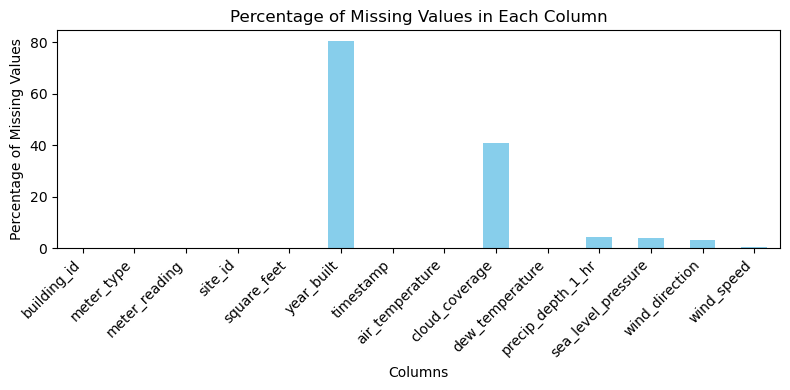

In [114]:
# Plotting the null values
# Assuming healthcare_df is your DataFrame
missing_percentage = healthcare_df.isna().mean() * 100

plt.figure(figsize=(8, 4))
missing_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

***Insights***\
There are two columns with >40% of null values and three near to 4% null values. Each column will be analyzed to either drop it or fill in missing data.

#### 1.2.2.1 'year_built' null values analysis
The objective is to review this column to decide whether to remove it entirely or handle its missing data.

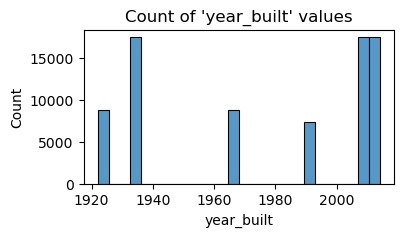

In [115]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['year_built'])
plt.title("Count of 'year_built' values")
plt.show()

In [116]:
# Percentage of current values
healthcare_df['year_built'].value_counts(normalize=True)

year_built
1934.0    0.226387
2010.0    0.226013
1922.0    0.113342
1966.0    0.113342
2014.0    0.113316
2012.0    0.112994
1990.0    0.094606
Name: proportion, dtype: float64

***Insights***
- This column will be retained for visualization analysis but omitted from the modeling process. 
It's unfortunate because this type of information would serve as n importantl predictor for energy consumption.
- 80.6 % records missing, which makes it too many to impute.

#### 1.2.2.2. `cloud_coverage` null values
The goal is to assess this column and determine whether to completely remove it or address the missing data within it.

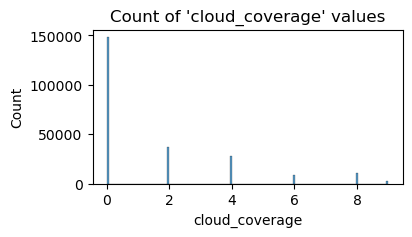

In [117]:
# Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['cloud_coverage'])
plt.title("Count of 'cloud_coverage' values")
plt.show()

In [118]:
# Percentage of current values
healthcare_df['cloud_coverage'].value_counts()/healthcare_df['cloud_coverage'].count()

cloud_coverage
0.0    0.631388
2.0    0.156045
4.0    0.120315
8.0    0.046317
6.0    0.034897
9.0    0.011037
Name: count, dtype: float64

***Insight***
- This column will be retained for visualization analysis but omitted from the modeling process. Retaining this column isn't critical, as this specific information doesn't significantly impact energy consumption predictions.
- 40.9 % records missing and of the remaining 63% equal to zero. which makes it too many to impute.

#### 1.2.2.3. `precip_depth_1_hr` null values
The objective is to evaluate this column and decide between completely removing it or handling the missing data contained within it.

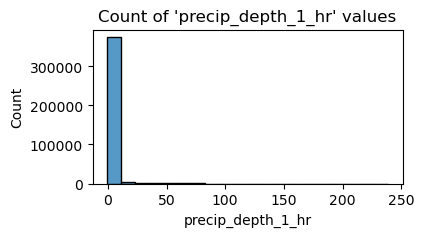

In [119]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['precip_depth_1_hr'])
plt.title("Count of 'precip_depth_1_hr' values")
plt.show()

In [120]:
# Percentage of values
healthcare_df['precip_depth_1_hr'].value_counts()/healthcare_df['precip_depth_1_hr'].count()

precip_depth_1_hr
 0.0      0.879589
-1.0      0.064660
 3.0      0.017646
 5.0      0.008413
 8.0      0.005606
            ...   
 132.0    0.000005
 147.0    0.000003
 211.0    0.000003
 180.0    0.000003
 239.0    0.000003
Name: count, Length: 71, dtype: float64

***Insight***
- While this column will be used for visualization analysis, it won't be included in the modeling process. Its retention isn't crucial as the information it holds doesn't notably influence energy consumption predictions.
- 4 % records missing and of the remaining 87% equal to zero and 6.4 equal to -1 (label for non information). The prevalence of zero values makes it impractical to attempt replacing the missing values.

#### 1.2.2.4 `sea_level_pressure` null values

The goal is to assess this column and make a decision regarding whether to entirely remove it or manage the missing data it contains 

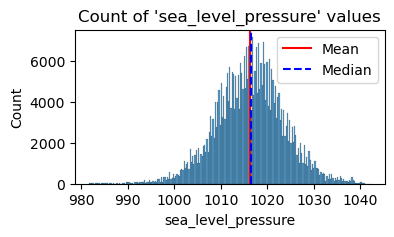

In [121]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Adding statistical lines and legend
plt.axvline(healthcare_df['sea_level_pressure'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['sea_level_pressure'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['sea_level_pressure'])
plt.title("Count of 'sea_level_pressure' values")
plt.show()

***Insight***
- 3.6 % records are missing.
- Replace missing values with the mean, since it is the same as the median

In [122]:
# Replace missing values with the mean
healthcare_df['sea_level_pressure'].fillna(healthcare_df['sea_level_pressure'].mean(), inplace=True)

In [123]:
# Check Percentage of null values per column equal to zero
healthcare_df['sea_level_pressure'].isna().sum()

0

#### 1.2.2.5 `wind_direction` null values
The objective is to evaluate this column and determine whether to eliminate it entirely or address its missing data.

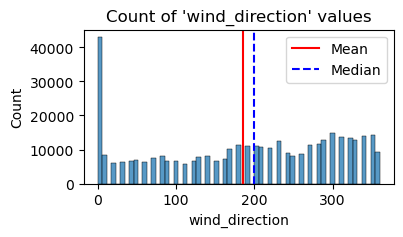

In [124]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))
plt.axvline(healthcare_df['wind_direction'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['wind_direction'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['wind_direction'])
plt.title("Count of 'wind_direction' values")
plt.show()

In [125]:
# Percentage of current values
healthcare_df['wind_direction'].value_counts()/healthcare_df['wind_direction'].count()

wind_direction
0.0      0.111684
300.0    0.038260
350.0    0.037093
340.0    0.036476
310.0    0.035520
320.0    0.034675
290.0    0.033441
330.0    0.032922
230.0    0.032290
280.0    0.030182
270.0    0.029363
180.0    0.029127
200.0    0.028310
190.0    0.028251
210.0    0.027808
220.0    0.027224
170.0    0.026330
360.0    0.024378
240.0    0.023510
260.0    0.022501
10.0     0.022141
140.0    0.021301
80.0     0.020834
250.0    0.020637
130.0    0.020096
70.0     0.019660
160.0    0.018732
50.0     0.017578
40.0     0.017493
90.0     0.017428
150.0    0.017296
120.0    0.017262
100.0    0.016928
30.0     0.016306
60.0     0.016088
20.0     0.015715
110.0    0.015092
202.0    0.000070
Name: count, dtype: float64

***Insight***
- 3.1% records are missing.
- Replace missing values with the mean, since it is the same as the median

In [126]:
# Replace missing values with the mean
healthcare_df['wind_direction'].fillna(healthcare_df['wind_direction'].mean(), inplace=True)

In [127]:
# Check Percentage of null values per column equal to zero
healthcare_df['wind_direction'].isna().sum()

0

#### 1.2.2.6 `wind_speed` null values

The aim is to assess this column and make a decision on whether to entirely remove it or address its missing data

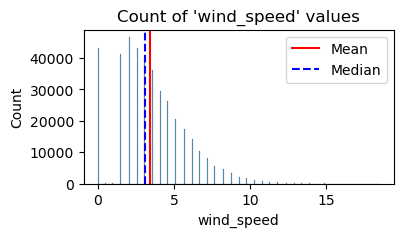

In [128]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))
plt.axvline(healthcare_df['wind_speed'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['wind_speed'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['wind_speed'])
plt.title("Count of 'wind_speed' values")
plt.show()

In [129]:
# Percentage of current values
healthcare_df['wind_speed'].value_counts()/healthcare_df['wind_speed'].count()

wind_speed
2.1     0.117426
2.6     0.108627
0.0     0.108461
1.5     0.103863
3.1     0.100349
3.6     0.090938
4.1     0.073924
4.6     0.065971
5.1     0.051750
5.7     0.043583
6.2     0.035302
6.7     0.026040
7.2     0.020767
7.7     0.014392
8.2     0.011678
8.8     0.008386
9.3     0.005414
9.8     0.004098
10.3    0.002469
10.8    0.002089
11.3    0.001269
11.8    0.000891
12.4    0.000541
1.0     0.000506
12.9    0.000347
13.4    0.000242
0.5     0.000176
13.9    0.000169
14.9    0.000083
2.2     0.000060
14.4    0.000058
16.0    0.000045
1.3     0.000023
15.4    0.000018
17.0    0.000015
10.0    0.000015
13.0    0.000005
16.5    0.000003
18.5    0.000003
8.0     0.000003
7.0     0.000003
Name: count, dtype: float64

***Insight***
- 0.2% records are missing.
- Replace missing values with the mean, since it is the same as the median

In [130]:
# Replace missing values with the mean
healthcare_df['wind_speed'].fillna(healthcare_df['wind_speed'].mean(), inplace=True)

In [131]:
# Check Percentage of null values per column equal to zero
healthcare_df['wind_speed'].isna().sum()

0

In [132]:
# Sanity check for percentage of null values per column
healthcare_df.isna().mean()*100

building_id            0.000000
meter_type             0.000000
meter_reading          0.000000
site_id                0.000000
square_feet            0.000000
year_built            80.553388
timestamp              0.134244
air_temperature        0.150303
cloud_coverage        40.959835
dew_temperature        0.154067
precip_depth_1_hr      4.084792
sea_level_pressure     0.000000
wind_direction         0.000000
wind_speed             0.000000
dtype: float64

***Insight***
- Columns containing missing values will be dropped before the modeling phase

[back to TOC](#toc)

<a id='hea-23'></a>

### 1.2.3 Duplicate values

In [133]:
# Dataset duplicated rows. 
healthcare_df.duplicated().sum()

# Calculate the percentage of duplicate rows
total_rows = len(healthcare_df)
percentage_duplicates = (healthcare_df.duplicated().sum() / total_rows) * 100
percentage_duplicates

0.0022583162495891118

***Insight***
- Given that there are only 0.002% duplicate rows, it's safe to drop them without concern for their impact on our results.

[back to TOC](#toc)

<a id='hea-3'></a>

## 1.2. Data visualization
Data set visualizations are valuable as they present complex information in a visually understandable format, aiding in identifying patterns, trends, and relationships within the data at a glance. Only the numerical columns will be used, having the target variable 'Reviewer_Score' as the main interest in the visualizations.

[back to TOC](#toc)

<a id='hea-31'></a>

### 1.2.2. Numerical columns analysis
We'll exclusively analyze columns containing numeric values to extract insights from them.

In [134]:
# Group numeric columns
numeric = list(healthcare_df.select_dtypes(exclude='object').columns)
print(numeric)

['building_id', 'meter_type', 'meter_reading', 'site_id', 'square_feet', 'year_built', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [135]:
# Statistic overview
healthcare_df[numeric].describe()

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,398527.000000,398527.000000,398527.000000,398527.000000,398527.000000,77500.000000,397992,397928.000000,235291.000000,397913.000000,382248.000000,398527.000000,398527.000000,398527.000000
mean,1093.571025,0.859126,738.597583,11.641382,138438.671365,1976.620568,2016-07-02 09:46:01.219320832,13.303335,1.472606,5.582175,0.747271,1016.294189,186.147621,3.449965
min,208.000000,0.000000,0.000000,2.000000,9813.000000,1922.000000,2016-01-01 00:00:00,-28.900000,0.000000,-31.700000,-1.000000,981.600000,0.000000,0.000000
25%,1207.000000,0.000000,34.020300,13.000000,35354.000000,1934.000000,2016-04-02 11:00:00,5.000000,0.000000,-2.200000,0.000000,1011.800000,90.000000,2.100000
50%,1243.000000,1.000000,211.858000,14.000000,115788.000000,1990.000000,2016-07-02 13:00:00,13.900000,0.000000,6.100000,0.000000,1016.294189,190.000000,3.100000
75%,1285.000000,2.000000,781.576000,14.000000,200000.000000,2010.000000,2016-10-01 23:00:00,22.200000,2.000000,14.400000,0.000000,1020.800000,290.000000,4.600000
max,1388.000000,3.000000,28189.500000,15.000000,819577.000000,2014.000000,2016-12-31 23:00:00,47.200000,9.000000,26.100000,239.000000,1042.200000,360.000000,18.500000
std,328.852552,0.944250,1364.722460,4.330688,141165.354721,36.478762,NaN,10.983677,2.344205,10.646586,6.126940,7.159881,114.769541,2.220054


**Insights**
- `meter_reading` is strongly positive skewed since the mean is far higher than the 50th percentile.

[back to TOC](#toc)

<a id='hea-32'></a>

### 1.2.2. Data distribution

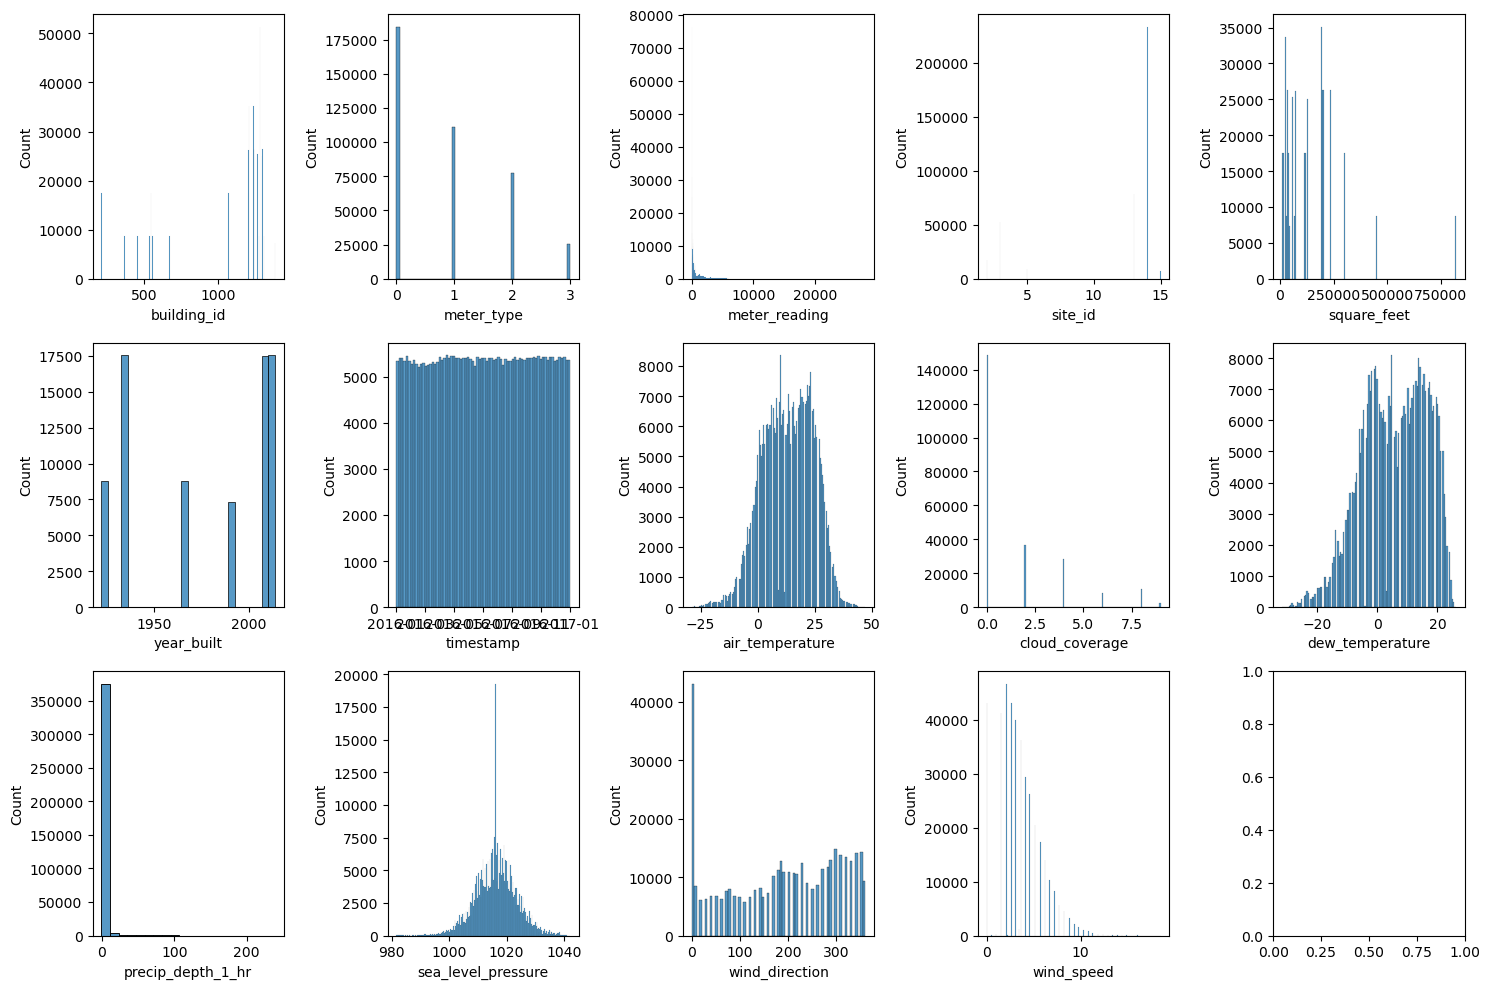

In [136]:
# Plotting the histograms 
plt.subplots(3,5, figsize=(15,10))

counter=1

for i in list(numeric):
    plt.subplot(3,5,counter)
    sns.histplot(healthcare_df[i])
    counter+=1

# Ensure proper spacing and no overlapping
plt.tight_layout()
plt.show()

***Insights***
- Positive skew for: `meter_reading`, `wind_speed`
- Bimodal distribution for `dew_temperature`
- Categorical structure for `meter_type`, `cloud_coverage`
- Normal distribution for: `sea_level_presure`

[back to TOC](#toc)

<a id='hea-33'></a>

### 1.2.3. Building ID and meter types

We'll visualize therelationshipn between healthcare buildings and the meters available for each of the buildings.

In [137]:
# Quantity of buildins available
healthcare_df['building_id'].nunique()

23

In [138]:
# Percentage of energy data points for each building
healthcare_df['building_id'].value_counts(normalize=True)

building_id
1241    0.088114
1303    0.066123
1245    0.066086
1286    0.066083
1243    0.066078
1207    0.065694
1269    0.063697
1285    0.062789
1300    0.062520
1072    0.044082
1208    0.044075
1209    0.044072
208     0.044025
365     0.022041
670     0.022041
1282    0.022041
1313    0.022041
547     0.022036
455     0.022036
548     0.021976
535     0.021976
556     0.021973
1388    0.018398
Name: proportion, dtype: float64

In [139]:
# Extracting unique values from the 'meter_type' column and converting to a list
meter_values = healthcare_df['meter_type'].unique().tolist()

print(meter_values)

[0, 1, 2, 3]


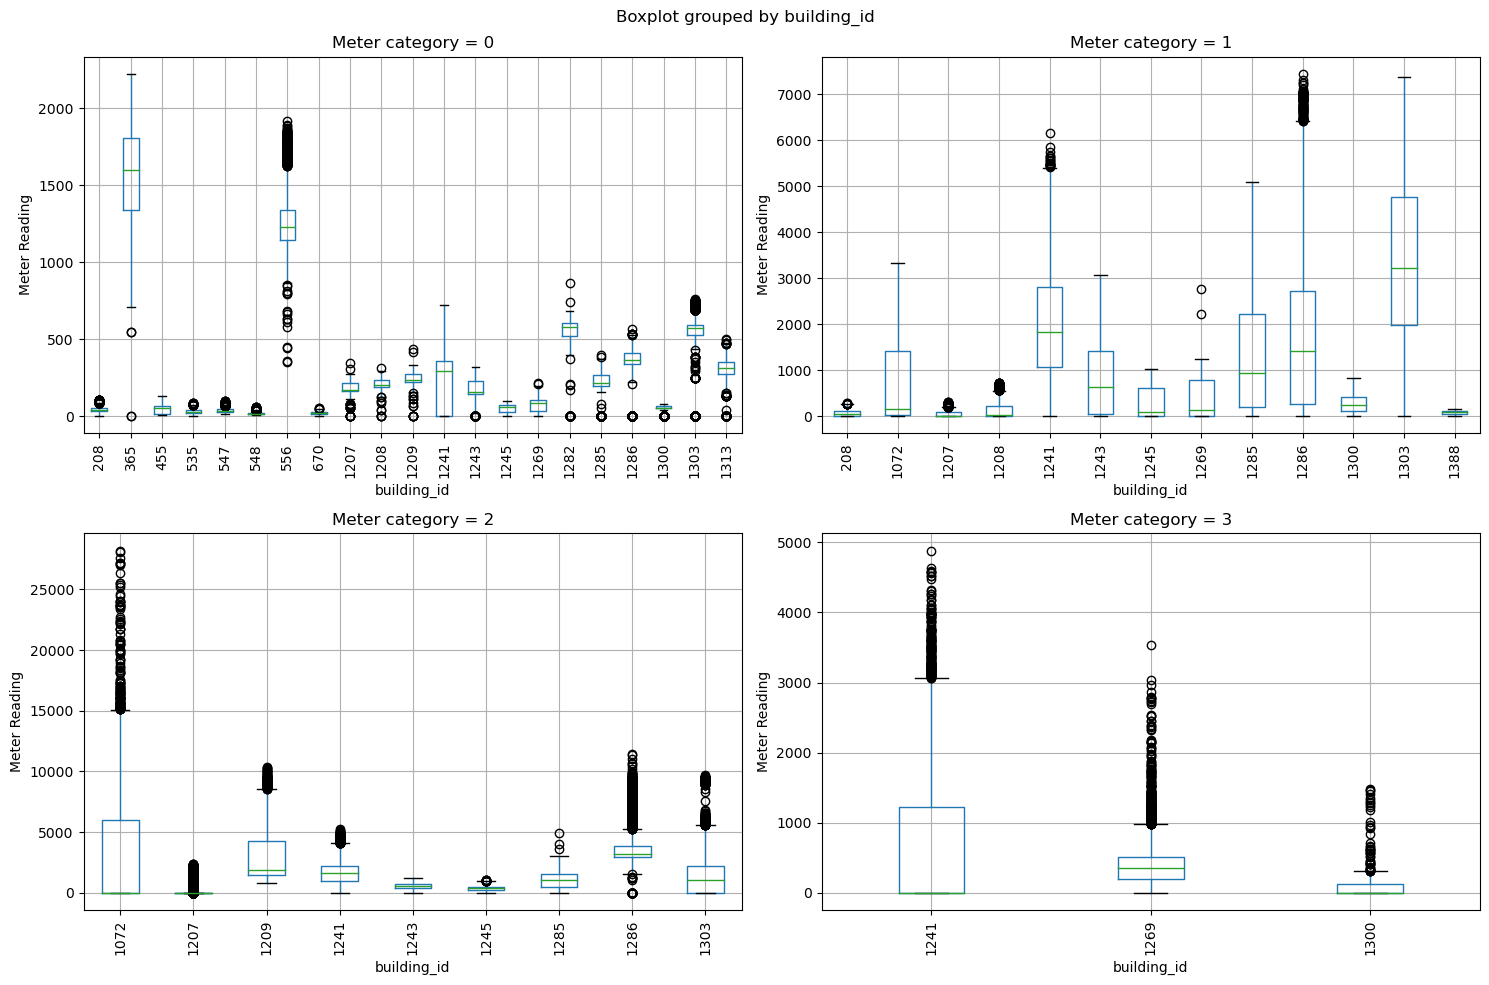

In [140]:
# Plotting data for 'meter' category 0: electricity, 1: chilled water, 2: steam, 3: hot water
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

counter = 0  # Start the counter at index 0

for i, ax in zip(meter_values, axes.flatten()):
    meter_data = healthcare_df[healthcare_df['meter_type'] == i]
    meter_data.boxplot(column='meter_reading', by='building_id', ax=ax)
    ax.set_title(f'Meter category = {i}')  # Set subplot title
    
    counter += 1  # Increment counter

    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    ax.set_ylabel('Meter Reading')  # Set y-axis label

# Ensure proper spacing and no overlapping
plt.tight_layout()
# Rotating x-labels to 45 degrees
plt.xticks(rotation=90)

plt.show()

**Insights**
- Not all 21 buildings have all 4 meters. Hence, it would be visualized only the meter_type for electricity (value 0) for the 3 buildings with more energy measurements.
- The meter_type for electricity refers only to plug loads. 
Plug loads refer to the energy consumed by devices or appliances that are plugged into electrical outlets within a building. 
- For the same meter each building have a different range of values. Which could be related to different floor area.

In [141]:
# Percentage of energy data points for each building with
healthcare_df[healthcare_df['meter_type'] == 0]['building_id'].value_counts(normalize=True)

building_id
1313    0.047650
1282    0.047650
1303    0.047650
1300    0.047650
1286    0.047650
670     0.047650
1285    0.047650
365     0.047650
1243    0.047650
1245    0.047650
1269    0.047650
1241    0.047644
455     0.047639
547     0.047639
1208    0.047634
1209    0.047628
1207    0.047617
208     0.047530
548     0.047509
535     0.047509
556     0.047503
Name: proportion, dtype: float64

***Insights***
- Buildings selected for further visualization: 1313, 1282, 1303

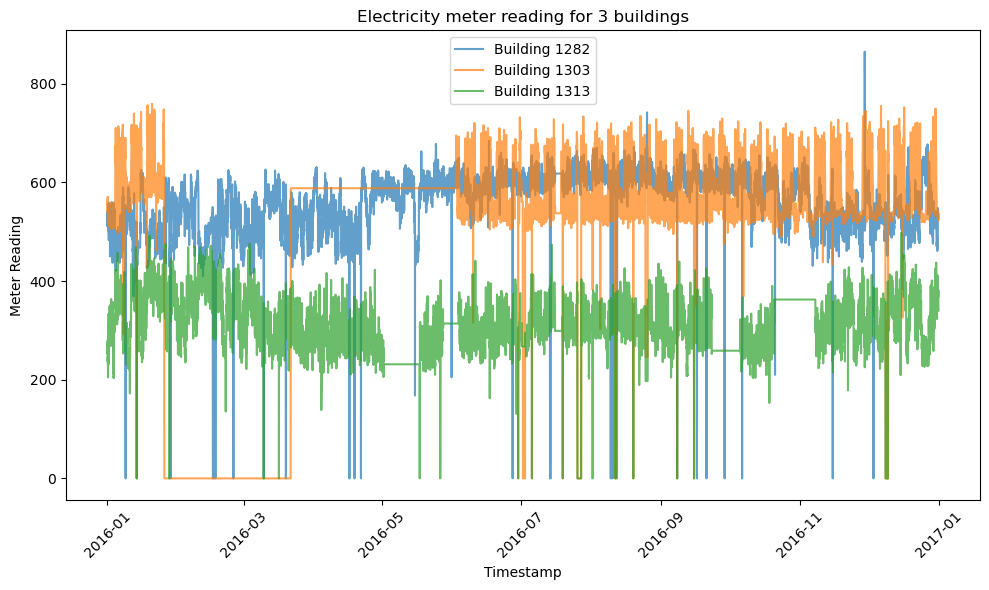

In [142]:
# Plot for specific buildings, for meter_type electricity 
# Specify building IDs of interest
building_ids_of_interest = [1313, 1282, 1303]

# Filter the 'health' DataFrame for the specified building IDs and meter_type
filtered_data = healthcare_df[(healthcare_df['building_id'].isin(building_ids_of_interest)) & (healthcare_df['meter_type'] == 0)]

plt.figure(figsize=(10, 6))

# Plotting each building's data separately
for building_id, group_data in filtered_data.groupby('building_id'):
    plt.plot(group_data['timestamp'], group_data['meter_reading'], linestyle='-', label=f"Building {building_id}", alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.title("Electricity meter reading for 3 buildings")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Insights***
- We'll proceed with the analysis focusing on building 1282 as it exhibits a more consistent pattern in its electricity measurements.

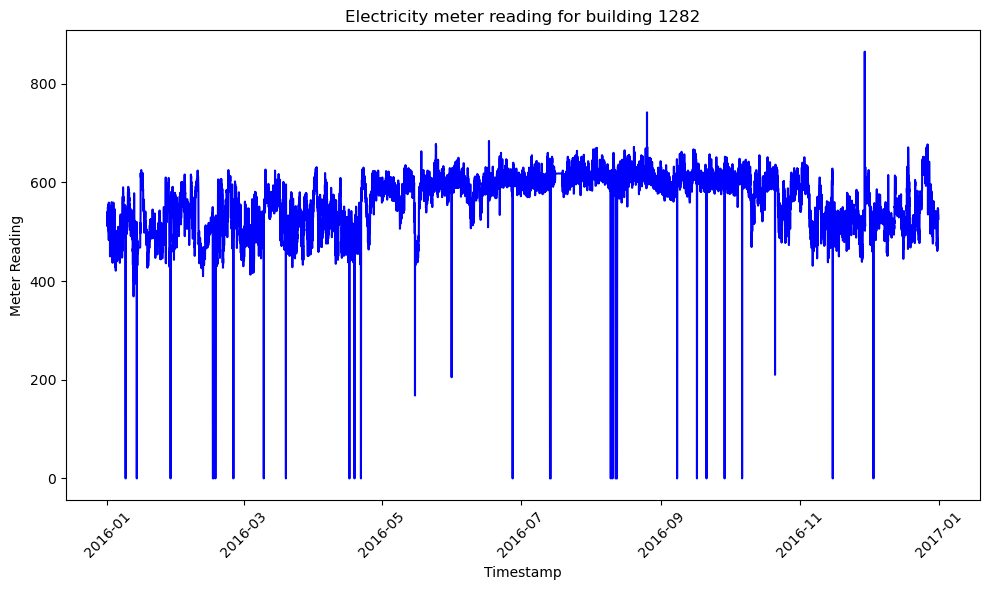

In [143]:
# Electricity plot only for building 1282 
# Assuming 'health' DataFrame contains your data
filtered_data = healthcare_df[(healthcare_df['building_id'] == 1282) & (healthcare_df['meter_type'] == 0)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data['timestamp'], filtered_data['meter_reading'], linestyle='-', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.title("Electricity meter reading for building 1282")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

***Insights***\
The electricity plot above indicates:
- It reveals seasonality in energy consumption over time, summer consumption is higher than winter.
- The trend is stable, meaning that it is flat for each season.
- Variation between peaks and troughs values is higher for summer season. About 200 kW for winter and 100 kW for summer.
- No cycles observed during the year. 
- Sudden spikes or drops could indicate irregular usage, potential faults, or anomalies that need further investigation.
- No relationships between timestamped events (like specific hours of the day, weekdays, or seasons) and energy consumption can be observed. A monthly analysis will be conducted to explore potential relationships.

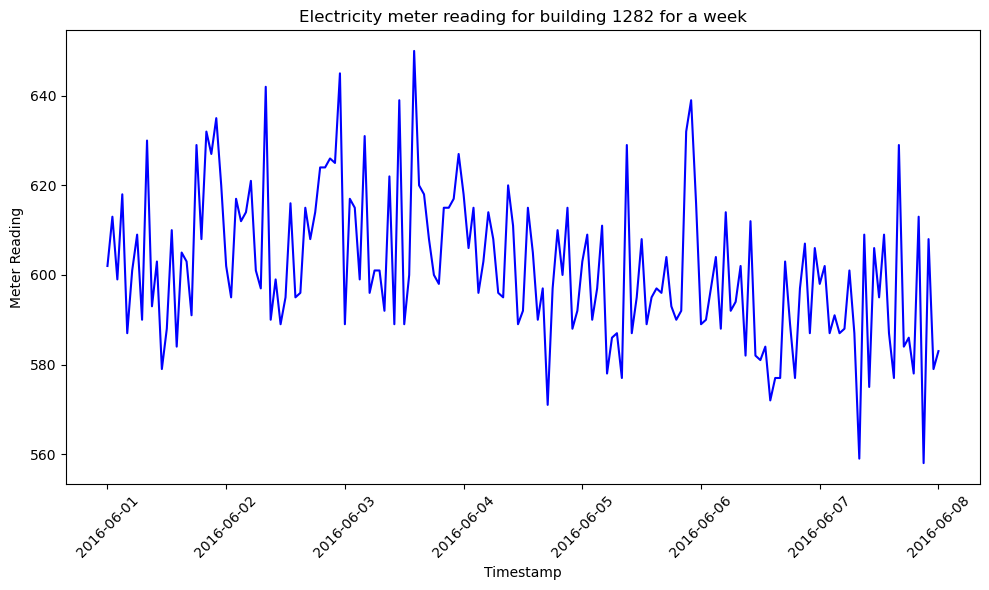

In [144]:
# Convert 'timestamp' column to datetime format
healthcare_df['timestamp'] = pd.to_datetime(healthcare_df['timestamp'])

# Filter the 'health' DataFrame for the specified conditions (building ID, meter_type, and timestamp range)
filtered_data = healthcare_df[
    (healthcare_df['building_id'] == 1282) &
    (healthcare_df['meter_type'] == 0) &
    (healthcare_df['timestamp'].between('2016-06-01', '2016-06-08'))
]

plt.figure(figsize=(10, 6))

# Plotting the data for building_id=1282 within the specified timestamp range
plt.plot(filtered_data['timestamp'], filtered_data['meter_reading'], linestyle='-', color='b')

plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.title("Electricity meter reading for building 1282 for a week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Insights***\
The electricy plot above indicates no relationships between timestamped events (like specific hours of the day, weekdays, or seasons) and energy consumption.

[back to TOC](#toc)

<a id='hea-34'></a>

### 1.2.4. Meter variables

#### 1.2.4.1 Meter type

In [145]:
# Percentage of unique 'meter' values
healthcare_df['meter_type'].value_counts(normalize=True)

meter_type
0    0.462566
1    0.279339
2    0.194499
3    0.063597
Name: proportion, dtype: float64

<Axes: xlabel='meter_type', ylabel='Count'>

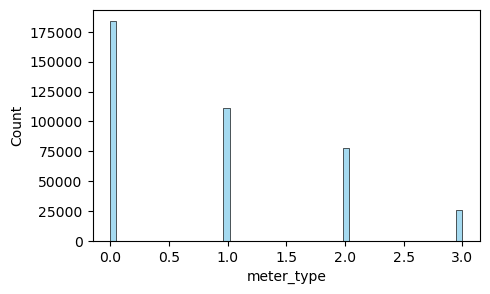

In [146]:
# Plot
plt.figure(figsize=(5,3))
sns.histplot(healthcare_df['meter_type'], color='skyblue')

***Insights***\
There is a categorical structure for this variable

#### 1.2.4.2. Meter reading

In [147]:
# Percentage of unique values
healthcare_df['meter_reading'].value_counts(normalize=True)

meter_reading
0.0000       0.087497
588.1900     0.004381
0.3748       0.002291
0.3332       0.002211
362.5400     0.001092
               ...   
230.1710     0.000003
2019.1500    0.000003
329.5960     0.000003
160.6970     0.000003
29.4019      0.000003
Name: proportion, Length: 195449, dtype: float64

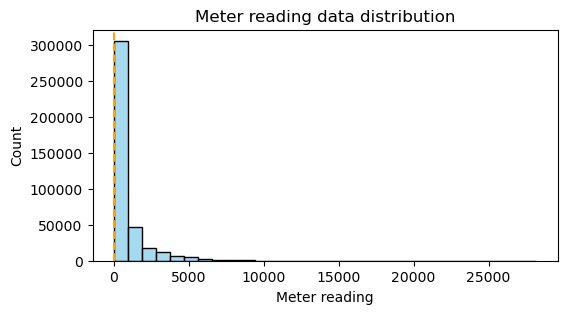

In [148]:
# Investigate meter_reading values for the full range of values
# Create histogram using Seaborn
plt.figure(figsize=(6,3))
sns.histplot(healthcare_df['meter_reading'], bins=30, color='skyblue')

# Adding a dotted vertical line where to zoom in
plt.axvline(x=1, color='orange', linestyle='--')

plt.xlabel('Meter reading')
plt.ylabel('Count')
plt.title('Meter reading data distribution')

plt.show()

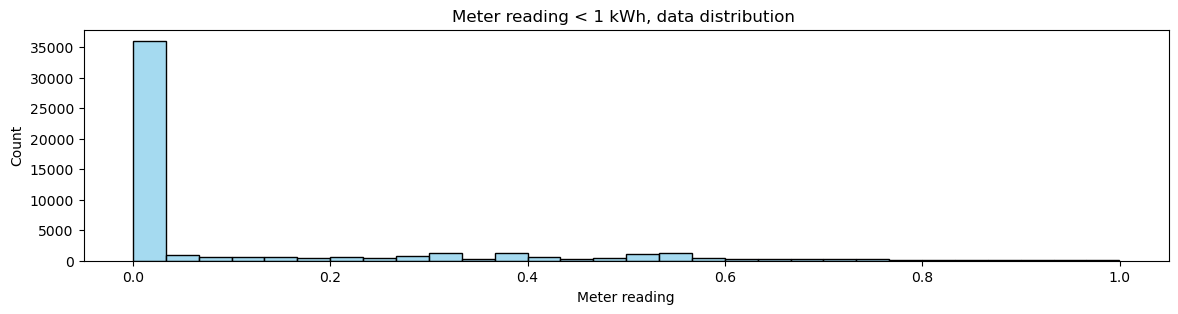

In [149]:
# Plot for count of meter_reading < 1

# Filtering data for 'meter_reading' 
filtered_data = healthcare_df[healthcare_df['meter_reading'] < 1]

# Creating a histogram using Seaborn
plt.figure(figsize=(14,3))
sns.histplot(filtered_data['meter_reading'], bins=30, color='skyblue')

plt.xlabel('Meter reading')
plt.ylabel('Count')
plt.title('Meter reading < 1 kWh, data distribution ')

plt.show()

***Insights***
- Presents positive skew data with a lot of values near zero.
- Values are in kWh units with are too small for hourly readings, change units to Wh.
- 8.7% of meter reading equal to zero (0)

[back to TOC](#toc)

<a id='hea-35'></a>

### 1.2.5. Weather variables

#### 1.2.5.1. Dew temperature

<Axes: xlabel='dew_temperature', ylabel='Count'>

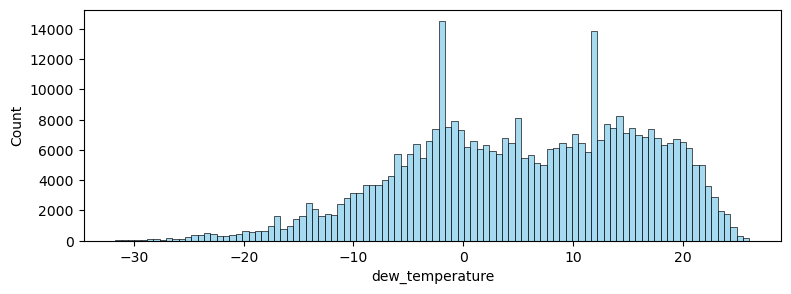

In [150]:
# Investigate meter_reading values for the full range of meter_reading values
# Create histogram using Seaborn
plt.figure(figsize=(9,3))
sns.histplot(healthcare_df['dew_temperature'], bins=100, color='skyblue')

***Insights***
- Exhibiting a bimodal distribution, indicating the presence of two distinct clusters of data, possibly suggesting diverse locations and climates.

#### 1.2.5.2. Cloud Coverage

<Axes: xlabel='cloud_coverage', ylabel='Count'>

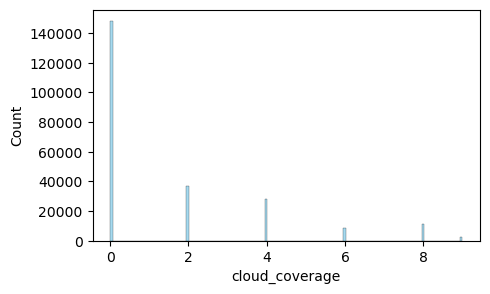

In [151]:
# Plot for 'cloud_coverage'
plt.figure(figsize=(5,3))
sns.histplot(healthcare_df['cloud_coverage'], color='skyblue')

***Insights***\
There is a categorical structure for this variable

[back to TOC](#toc)

<a id='hea-40'></a>

## 1.4. Statistical Analysis
Statistical analysis will help reveal patterns, relationships, and trends crucial for understanding customer preferences and guiding decisions to enhance hotel service and satisfaction..

[back to TOC](#toc)

<a id='hea-41'></a>

### 1.4.1. Columns correlation
In this section, we aim to determine the columns that exhibit positive or negative correlations with the target variable (meter_reading) and assess the statistical significance of these correlations

**Preparing data**\
To carry on the correlation analysis only the columns with numerical values will be used.

In [152]:
healthcare_df.head()

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,208,0,77.2900,2,36904,1934.0,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
1,208,1,0.1055,2,36904,1934.0,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2,208,0,87.0900,2,36904,1934.0,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
3,208,1,0.1407,2,36904,1934.0,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
4,208,0,90.5100,2,36904,1934.0,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.0,270.0,3.1


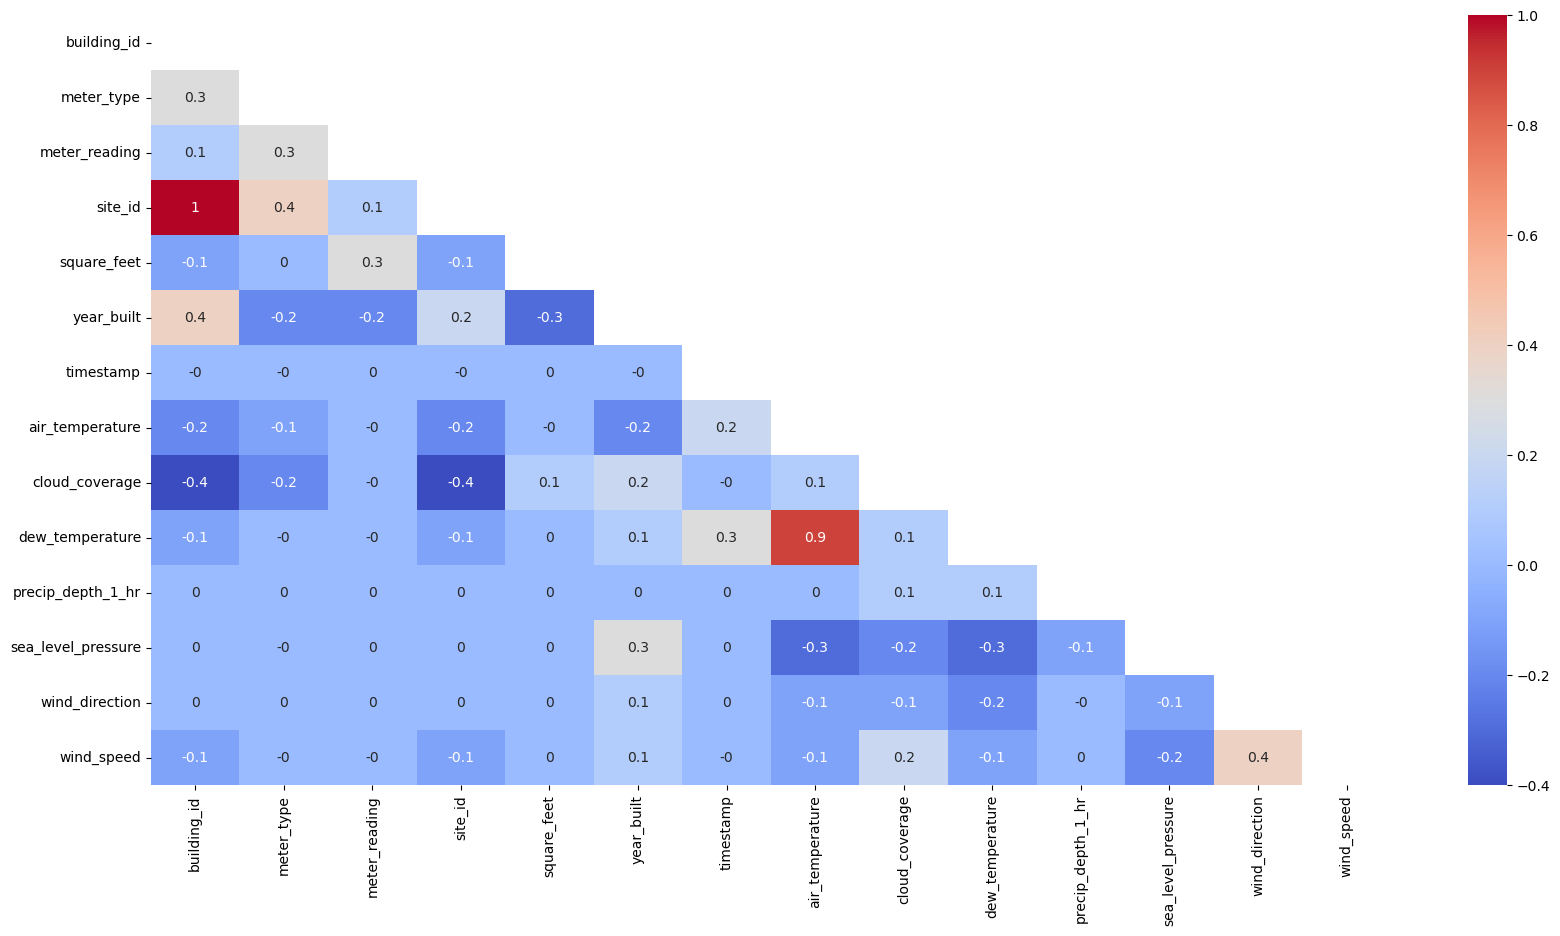

In [153]:
# Correlation of the variables in a heatmap for an initial idea
plt.figure(figsize=(20, 10))
matrix = np.triu(healthcare_df.corr())
sns.heatmap(healthcare_df.corr().round(1), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

In [154]:
# Collect correlation coefficients to enable a more detailed visualization. 
# While the heat map offers an initial insight into correlations, a closer visualization can enhance the understanding of the information.

corr_coef = healthcare_df.corr()
corr_coef = pd.DataFrame(corr_coef['meter_reading'])
corr_coef.drop(index='meter_reading', inplace=True)
corr_coef.columns=['Correlation_Coefficient']
corr_coef

,Correlation_Coefficient
building_id,0.122030
meter_type,0.269728
site_id,0.138361
square_feet,0.325410
year_built,-0.225351
timestamp,0.009871
air_temperature,-0.027513
cloud_coverage,-0.033787
dew_temperature,-0.002399
precip_depth_1_hr,0.002167


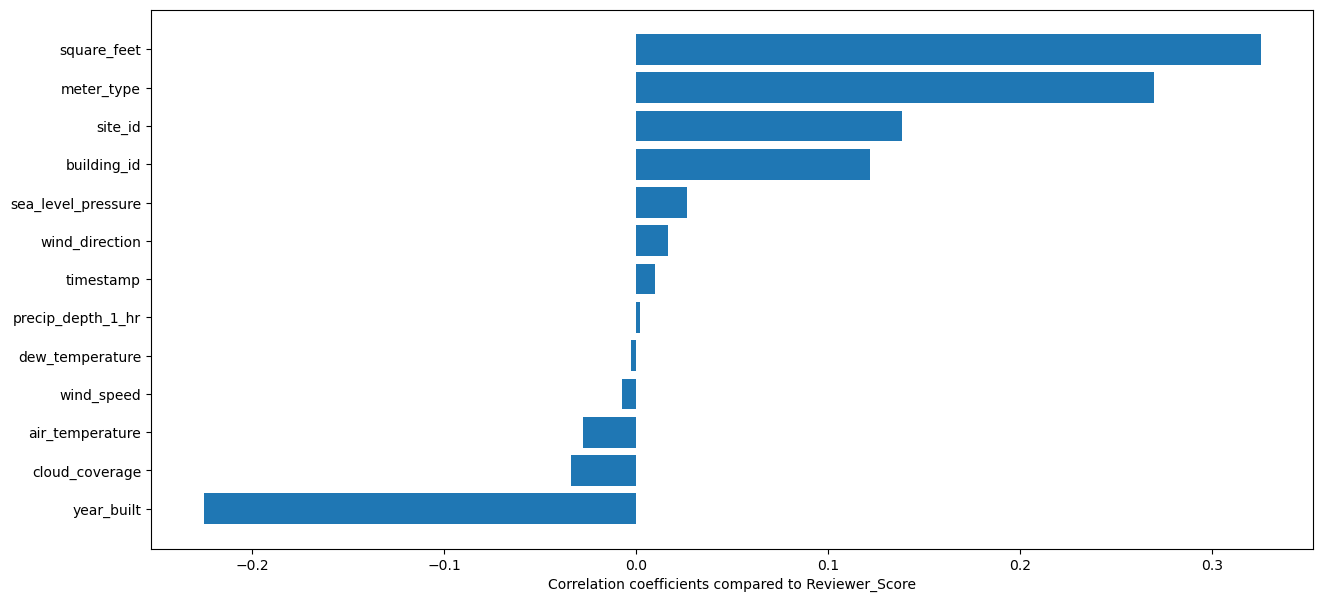

In [155]:
# Visualization and comparison of correlation coefficients.
corr_coef.sort_values(by='Correlation_Coefficient', inplace=True)

plt.figure(figsize=(15,7))
plt.barh(corr_coef.index,corr_coef['Correlation_Coefficient'])
plt.xlabel('Correlation coefficients compared to Reviewer_Score')
plt.show()

***Insights***
- The variable `square_feet` exhibits the highest correlation coefficient, suggesting increased energy consumption with larger building areas.
- Conversely, the `year_built` variable portrays the lowest correlation coefficient, indicating lower energy consumption in older buildings.

[back to TOC](#toc)

<a id='mod-00'></a>

# 2. Modelling
Modeling, including time series analysis, plays a critical role in uncovering patterns, predicting outcomes, and pinpointing crucial factors affecting the target variable, providing valuable insights for decision-making. In the context of this energy consumption prediction model for buildings, incorporating time series analysis optimizes efficiency and informs decisions for sustainable building management.

Time series was chosen as the dataset consist of a sequence of energy consumption observations indexed by data-time (hourly). Time series forecasting aims to predict how energy consumption will continue in the future based on historical patterns..

In [156]:
# Import libraries
# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

[back to TOC](#toc)

<a id='mod-01'></a>

## 2.1 Dataframe preparation
In this section 
Delete unnecessary columns, only used for EDA
Set index to `timestamp`

In [157]:
# Drop the unnecessary columns, only used for EDA
healthcare_df.drop(columns=['year_built','cloud_coverage','precip_depth_1_hr'], inplace=True)

In [158]:
# Ensuring that columns have been removed
healthcare_df.head()

,building_id,meter_type,meter_reading,site_id,square_feet,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,208,0,77.2900,2,36904,2016-01-01 00:00:00,15.6,-5.6,1015.3,270.0,3.6
1,208,1,0.1055,2,36904,2016-01-01 00:00:00,15.6,-5.6,1015.3,270.0,3.6
2,208,0,87.0900,2,36904,2016-01-01 01:00:00,13.9,-5.6,1015.6,270.0,4.1
3,208,1,0.1407,2,36904,2016-01-01 01:00:00,13.9,-5.6,1015.6,270.0,4.1
4,208,0,90.5100,2,36904,2016-01-01 02:00:00,13.3,-5.6,1016.0,270.0,3.1


In [159]:
# Filter dataset only for building 1282 and electricity meter type 
healthcare_1282_df = healthcare_df[(healthcare_df['building_id'] == 1282) & (healthcare_df['meter_type'] == 0)]
healthcare_1282_df

,building_id,meter_type,meter_reading,site_id,square_feet,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
271000,1282,0,537.0,14,12500,NaT,NaN,NaN,1016.294189,186.147621,3.449965
271001,1282,0,512.0,14,12500,2016-01-01 01:00:00,5.6,-0.6,1019.300000,300.000000,2.600000
271002,1282,0,541.0,14,12500,2016-01-01 02:00:00,5.6,-0.6,1019.400000,300.000000,2.600000
271003,1282,0,522.0,14,12500,2016-01-01 03:00:00,5.6,-1.1,1019.400000,186.147621,1.500000
271004,1282,0,531.0,14,12500,2016-01-01 04:00:00,5.0,-2.2,1019.200000,290.000000,3.100000
...,...,...,...,...,...,...,...,...,...,...,...
279779,1282,0,546.0,14,12500,2016-12-31 19:00:00,6.7,-8.3,1015.800000,200.000000,6.700000
279780,1282,0,537.0,14,12500,2016-12-31 20:00:00,5.6,-6.7,1015.300000,200.000000,5.700000
279781,1282,0,536.0,14,12500,2016-12-31 21:00:00,5.6,-6.7,1014.900000,190.000000,5.700000
279782,1282,0,534.0,14,12500,2016-12-31 22:00:00,5.6,-6.7,1014.000000,190.000000,6.700000


In [160]:
# Convert `timestamp` to datetime datatype and set it to index

healthcare_1282_df['timestamp'] = pd.to_datetime(healthcare_1282_df['timestamp'])
healthcare_1282_df = healthcare_1282_df.set_index('timestamp')

healthcare_1282_df.head()

,building_id,meter_type,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,,
NaT,1282,0,537.0,14,12500,NaN,NaN,1016.294189,186.147621,3.449965
2016-01-01 01:00:00,1282,0,512.0,14,12500,5.6,-0.6,1019.300000,300.000000,2.600000
2016-01-01 02:00:00,1282,0,541.0,14,12500,5.6,-0.6,1019.400000,300.000000,2.600000
2016-01-01 03:00:00,1282,0,522.0,14,12500,5.6,-1.1,1019.400000,186.147621,1.500000
2016-01-01 04:00:00,1282,0,531.0,14,12500,5.0,-2.2,1019.200000,290.000000,3.100000


In [161]:
# Confir that index is set to 'DatetimeIndex'
healthcare_1282_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, NaT to 2016-12-31 23:00:00
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         8784 non-null   int64  
 1   meter_type          8784 non-null   int64  
 2   meter_reading       8784 non-null   float64
 3   site_id             8784 non-null   int64  
 4   square_feet         8784 non-null   int64  
 5   air_temperature     8776 non-null   float64
 6   dew_temperature     8776 non-null   float64
 7   sea_level_pressure  8784 non-null   float64
 8   wind_direction      8784 non-null   float64
 9   wind_speed          8784 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 754.9 KB


In [174]:
# Examining the electricity usage pattern across time.
# add lines for each column
fig = px.line(healthcare_1282_df, x=healthcare_1282_df.index, y=healthcare_1282_df.meter_reading)

# axis labels and title
fig.update_layout(
    yaxis_title="Electricity consumption (Wh)", 
    legend_title="", 
    title="Electricity consumption for building 1282 in 2016"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

[back to TOC](#toc)

<a id='mod-02'></a>

## 2.2. Time Series Data Cleaning & EDA
The primary objective is to comprehensively grasp the data, addressing potential missing values and anomalies, including any absent dates.

In [163]:
# Dataset shape
healthcare_1282_df.shape

(8784, 10)

In [164]:
# Extract different datetime characteristics or perform calculations using dates.
first_day = healthcare_1282_df.index.min()
last_day = healthcare_1282_df.index.max()

# pandas `Timestamp` objects
first_day, last_day

(Timestamp('2016-01-01 01:00:00'), Timestamp('2016-12-31 23:00:00'))

### 2.2.1. Missing values and dates 
Initially, we'll verify whether any dates are absent from our index, ensuring we have a record for each day between the first and last rows.

In [165]:
# Let's look at the entire range of hourly values to identify dates present in the full range 
# but not included in the index.
full_range = pd.date_range(start=first_day, end=last_day, freq="H")

full_range.difference(healthcare_1282_df.index)

DatetimeIndex(['2016-06-12 06:00:00', '2016-06-12 07:00:00',
               '2016-06-12 08:00:00', '2016-06-12 09:00:00',
               '2016-06-12 10:00:00', '2016-06-12 11:00:00'],
              dtype='datetime64[ns]', freq=None)

In [167]:
# Same analysis using a different approach
healthcare_1282_df.isna().sum()

building_id           0
meter_type            0
meter_reading         0
site_id               0
square_feet           0
air_temperature       8
dew_temperature       8
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

***Insights***
- The dataset doesn't contain any missing hours with data. Just some columns with a few missing values.

### 2.2.2. Exploring time-of-year
As we're looking at larger trends, we'll convert our hourly records into daily data by combining the hour-to-hour values into one total for each day.


In [168]:
healthcare_daily = healthcare_1282_df.resample("D").sum()

healthcare_daily.head()

,building_id,meter_type,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,,
2016-01-01,29486,0,12082.0,322,287500,90.5,-75.5,23408.2,6556.147621,77.6
2016-01-02,30768,0,12145.0,336,300000,42.3,-182.8,24420.7,6736.147621,73.4
2016-01-03,30768,0,12089.0,336,300000,36.6,-127.9,24291.7,4950.000000,64.9
2016-01-04,30768,0,11434.0,336,300000,-21.6,-241.6,24363.2,7810.000000,110.9
2016-01-05,30768,0,11518.0,336,300000,-198.2,-464.3,24770.7,7360.000000,111.9


In [169]:
# Check the shape
healthcare_daily.shape

(366, 10)

In [173]:
# Plotting the electricity consumption for building 1282 in 2016
fig = px.line(healthcare_daily, x=healthcare_daily.index, y="meter_reading",)
fig.update_layout(
    yaxis_title="Electricity consumption (Wh)", 
    xaxis_title="Month",
    legend_title="", 
    title="Electricity consumption for building 1282 in 2016"
)
fig.show()

In [182]:
# daily average
daily_mean = healthcare_daily.groupby(healthcare_daily.index.day_name()).mean()

# relative deviation from the overall mean
daily_mean_diff = (daily_mean - daily_mean.mean())/daily_mean

# day names in right order
day_names = pd.date_range(start='2000-01', freq='D', periods=7).day_name()

# reorder columns to follow the day order
daily_mean_diff = daily_mean_diff.loc[day_names, ]

daily_mean_diff.T

,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday
building_id,0.000799,-0.004028,0.000799,0.000799,0.000799,0.000799,0.000013
meter_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meter_reading,0.002062,-0.004113,-0.009738,0.003359,0.009567,-0.006282,0.004863
site_id,0.000799,-0.004028,0.000799,0.000799,0.000799,0.000799,0.000013
square_feet,0.000799,-0.004028,0.000799,0.000799,0.000799,0.000799,0.000013
air_temperature,-0.043509,-0.015494,-0.041125,0.007132,0.028526,0.039174,0.018775
dew_temperature,-0.009636,-0.119074,-0.152299,0.017538,0.039236,0.107957,0.064026
sea_level_pressure,0.000821,-0.004052,0.001185,0.001345,0.001285,0.000214,-0.000822
wind_direction,-0.071121,0.045953,0.022855,0.037965,0.001521,-0.107139,0.048188
wind_speed,-0.017073,0.040693,0.019805,0.034102,-0.071910,-0.059979,0.040791


In [187]:
# 
fig = px.bar(daily_mean_diff, y='meter_reading')

fig.update_layout(
    yaxis_title="", 
    yaxis_tickformat = '%',
    xaxis_title="",
    title="Daily deviation from mean electricity consumption (%)",
    showlegend=False,
)
fig.show()

***Insights***
- On average Mondays consume 1% less electricity than the average day.
- On average Wednesdays consume 1% more electricity than the average day.

[back to TOC](#toc)

<a id='mod-03'></a>

## 2.3 Trend-Seasonal Decomposition 
To forecast a time series, it's essential to simplify it by extracting the trend and seasonal components, focusing on predicting the residual.

In [190]:
# decompose the time series
import statsmodels.api as sm

# Assuming healthcare_daily is your daily time series data
healthcare_daily = healthcare_daily['meter_reading']  # Consider only the 'meter_reading' column if necessary

# Ensure the index is in datetime format
healthcare_daily.index = pd.to_datetime(healthcare_daily.index)

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(healthcare_daily, model='additive')

In [191]:
type(decomposition)

statsmodels.tsa.seasonal.DecomposeResult

In [192]:
# add the decomposition data

healthcare_daily["Trend"] = decomposition.trend
healthcare_daily["Seasonal"] = decomposition.seasonal
healthcare_daily["Residual"] = decomposition.resid

healthcare_daily.head(10)

timestamp
2016-01-01 00:00:00    12082.0
2016-01-02 00:00:00    12145.0
2016-01-03 00:00:00    12089.0
2016-01-04 00:00:00    11434.0
2016-01-05 00:00:00    11518.0
2016-01-06 00:00:00    11512.0
2016-01-07 00:00:00    12029.0
2016-01-08 00:00:00    12367.0
2016-01-09 00:00:00    10977.0
2016-01-10 00:00:00    13572.0
Name: meter_reading, dtype: object

In [194]:
# Plotting the Trend, Seasonal and Residual
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=healthcare_daily.index, y=healthcare_daily[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

***Insights***
- There's a slight upward trend that plateaus before and after May
- The seasonal plot illustrates consistent daily variations.
- The residual component does not have a clear pattern. It also exhibits heteroscedasticity, indicating changing variance within it.

[back to TOC](#toc)

<a id='concl'></a>

# 4. Conclusion
- There's a slight upward trend that plateaus before and after May
- The seasonal plot illustrates consistent daily variations.
- The residual component does not have a clear pattern. It also exhibits heteroscedasticity, indicating changing variance within it.

[back to TOC](#toc)